In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

from scipy import stats

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import ElasticNet
from itertools import product

from boruta import BorutaPy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import VarianceThreshold

from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

### Imports

In [21]:
# read dataset

p = 0.1  # 30% of the lines
# keep the header, then take only 10% of lines
# if random from [0,1] interval is greater than 0.1 the row will be skipped
df_all = pd.read_csv(
         "../Output/../Output/Chunk_Breast.csv",
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p)

#df_breast = pd.read_csv("../Output/Chunk_Breast.csv", index_col=0)
#df_breast.info()

In [22]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Columns: 19665 entries, Unnamed: 0 to ENSG00000181518.3
dtypes: float64(19663), int64(1), object(1)
memory usage: 17.9+ MB


In [23]:
# create X and y

X = df_breast.drop("label", axis=1)
y = df_breast["label"]

In [24]:
# filter X with std

X_filter_std3 = X.loc[:, X.std() > 3]
X_filter_std3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1159 entries, TCGA-C8-A1HL-01 to GTEX-1117F-2826-SM-5GZXL
Columns: 1614 entries, ENSG00000229637.3 to ENSG00000186115.12
dtypes: float64(1614)
memory usage: 14.3+ MB


### split

In [25]:
# set seed for all random

SEED=1888

In [26]:
# split train to train and test

X_train, X_test, y_train, y_test = train_test_split(X_filter_std3, y, test_size=0.3, random_state=SEED)

### SMOTE

In [27]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (811, 1614)
Number transactions y_train dataset:  (811,)
Number transactions X_test dataset:  (348, 1614)
Number transactions y_test dataset:  (348,)


In [28]:
# upsampling with SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=SEED)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 757
Before OverSampling, counts of label '0': 54 

After OverSampling, the shape of train_X: (1514, 1614)
After OverSampling, the shape of train_y: (1514,) 

After OverSampling, counts of label '1': 757
After OverSampling, counts of label '0': 757


In [29]:
# get column names

column_names = X_train.columns

In [30]:
# numpy array from SMOTE back to df

X_train_smote = pd.DataFrame(X_train_res, columns=column_names)
#X_train_smote

### Lasso

In [14]:
# Lasso

lasso = Lasso(random_state=SEED)
lasso = lasso.fit(X_train_smote, y_train_res)

train_score = lasso.score(X_test, y_test)
coeff_used = np.sum(lasso.coef_!=0)

print(train_score)
print(coeff_used)

cv_scores = cross_val_score(lasso, X_train_smote, y_train_res, cv=5)

print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

0.6527102424906222
6
[0.63093666 0.29894409 0.6678387  0.         0.        ]
Average 5-Fold CV Score: 0.31954389128821237


In [15]:
lasso.coef_

array([-0.,  0.,  0., ..., -0., -0.,  0.])

In [16]:
X_train.columns

Index(['ENSG00000242268.2', 'ENSG00000269416.5', 'ENSG00000275265.1',
       'ENSG00000233540.1', 'ENSG00000270469.1', 'ENSG00000214062.5',
       'ENSG00000265096.1', 'ENSG00000229637.3', 'ENSG00000266644.1',
       'ENSG00000214541.3',
       ...
       'ENSG00000248869.5', 'ENSG00000270987.1', 'ENSG00000279507.1',
       'ENSG00000214216.10', 'ENSG00000233845.1', 'ENSG00000264491.1',
       'ENSG00000253333.1', 'ENSG00000186115.12', 'ENSG00000267117.1',
       'ENSG00000273233.1'],
      dtype='object', length=8264)

In [17]:
array_df = pd.DataFrame(lasso.coef_)
array_df.head()

,0
0,-0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [18]:
array_df.index = X_train.columns

In [19]:
array_df.min()

0   -0.008578
dtype: float64

In [20]:
array_df.shape

(8264, 1)

In [21]:
array_df.sort_values(0, ascending=False).head(10)

,0
ENSG00000170373.8,0.018887
ENSG00000262533.1,0.016066
ENSG00000229237.2,0.004283
ENSG00000219928.2,0.003385
ENSG00000230838.1,0.000915
ENSG00000273342.1,-0.000000
ENSG00000205662.2,0.000000
ENSG00000273138.1,-0.000000
ENSG00000186867.10,0.000000
ENSG00000242268.2,-0.000000


### LassoCV

In [22]:
# LassoCV

lassoCV = LassoCV(cv=5, random_state=SEED).fit(X_train_smote, y_train_res)
lassoCV.score(X_train_smote, y_train_res)

0.9992766815067534

In [84]:
lassoCV.coef_

array([-0.,  0.,  0., ..., -0.,  0.,  0.])

In [58]:
def imp_coef(model, columns=X_train.columns, n=20):
    array_to_df = pd.DataFrame(model.coef_)
    array_to_df.index = columns
    array_sorted = array_to_df.sort_values(0, ascending=False)
    imp_coef = pd.concat([array_sorted.head(n), array_sorted.tail(n)])
    
    return imp_coef

In [63]:
lassoCV_coef = imp_coef(lassoCV)
lassoCV_coef

,0
ENSG00000224126.2,0.006335
ENSG00000229237.2,0.005937
ENSG00000238249.2,0.004811
ENSG00000241431.1,0.003792
ENSG00000219928.2,0.003779
ENSG00000244538.1,0.003105
ENSG00000235734.4,0.002988
ENSG00000236060.2,0.002367
ENSG00000123500.9,0.001985
ENSG00000279473.1,0.001888


### LassoCV with SelectFromModel

In [77]:
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_boston.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-boston-py

In [57]:
# Lasso with SelectFromModel

clf = LassoCV(cv=5, random_state=SEED) # use the base estimator since the L1 promotes sparsity of features

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.00001)
sfm.fit(X_train_smote, y_train_res)
n_features = sfm.transform(X_train_smote).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.

while n_features > 40:
    sfm.threshold += 0.00001
    X_transform = sfm.transform(X_train_smote)
    n_features = X_transform.shape[1]
    
n_features

40

In [111]:
X_train_smote.head()
X_train_smote.columns[sfm.get_support()]

Index(['ENSG00000240247.6', 'ENSG00000279473.1', 'ENSG00000219928.2',
       'ENSG00000232679.1', 'ENSG00000256500.5', 'ENSG00000224557.7',
       'ENSG00000236060.2', 'ENSG00000224126.2', 'ENSG00000129824.15',
       'ENSG00000229237.2', 'ENSG00000197616.11', 'ENSG00000241431.1',
       'ENSG00000115386.5', 'ENSG00000244538.1', 'ENSG00000230734.1',
       'ENSG00000175646.3', 'ENSG00000279084.1', 'ENSG00000225558.1',
       'ENSG00000123500.9', 'ENSG00000262533.1', 'ENSG00000238249.2',
       'ENSG00000142789.19', 'ENSG00000235734.4', 'ENSG00000100721.10',
       'ENSG00000248873.1'],
      dtype='object')

In [50]:
X_transform_df = pd.DataFrame(X_transform)
X_transform_df.columns = X_train_smote.columns[sfm.get_support()]
X_transform_df.head()

,ENSG00000240247.6,ENSG00000279473.1,ENSG00000219928.2,ENSG00000232679.1,ENSG00000256500.5,ENSG00000224557.7,ENSG00000236060.2,ENSG00000224126.2,ENSG00000129824.15,ENSG00000229237.2,...,ENSG00000175646.3,ENSG00000279084.1,ENSG00000225558.1,ENSG00000123500.9,ENSG00000262533.1,ENSG00000238249.2,ENSG00000142789.19,ENSG00000235734.4,ENSG00000100721.10,ENSG00000248873.1
0,-4.0350,-1.1172,9.0743,1.8484,3.0234,-1.8314,6.8225,3.6928,-9.9658,2.2753,...,-9.9658,-4.2934,-1.3183,9.2998,3.3293,-0.8084,-9.9658,2.3704,-3.1714,-4.2934
1,-9.9658,-9.9658,1.7403,-9.9658,-9.9658,-2.3884,-9.9658,-9.9658,-0.2498,-9.9658,...,-2.3147,-9.9658,-9.9658,-1.1172,-9.9658,-9.9658,-9.9658,-0.4521,-9.9658,-2.5479
2,-9.9658,-1.8314,8.1521,0.7233,1.7660,-0.8339,4.4344,3.0978,-9.9658,2.0844,...,-9.9658,-9.9658,-0.4325,8.3797,2.7487,-2.1140,-9.9658,2.3308,-9.9658,-2.7274
3,-9.9658,-3.6259,7.2695,3.1491,2.2573,-3.3076,4.4900,2.8994,-9.9658,2.9319,...,-9.9658,-9.9658,-0.6873,6.9021,3.2267,-2.1779,-9.9658,2.7721,-2.0529,-5.0116
4,1.8564,-9.9658,1.0079,-9.9658,0.0014,-9.9658,-0.6873,-9.9658,-0.1031,-9.9658,...,1.5514,-3.1714,-9.9658,-2.7274,-9.9658,-9.9658,2.3394,-9.9658,-3.8160,-1.3921


In [74]:
list1 = lassoCV_coef.index.tolist()

In [75]:
list2 = X_transform_df.columns.tolist()

In [78]:
print(list1 == list2)

False


In [81]:
set1 = set(list1)
set2 = set(list2)

In [85]:
(set1 - set2)

{'ENSG00000147434.8',
 'ENSG00000162840.4',
 'ENSG00000168530.15',
 'ENSG00000169474.4',
 'ENSG00000172867.3',
 'ENSG00000189398.5',
 'ENSG00000204866.8',
 'ENSG00000206913.1',
 'ENSG00000214881.4',
 'ENSG00000235912.1',
 'ENSG00000248583.1',
 'ENSG00000253683.1',
 'ENSG00000259738.1',
 'ENSG00000265415.1',
 'ENSG00000267143.1'}

In [80]:
set(list1) & set(list2)

{'ENSG00000100721.10',
 'ENSG00000115386.5',
 'ENSG00000123500.9',
 'ENSG00000129824.15',
 'ENSG00000142789.19',
 'ENSG00000175646.3',
 'ENSG00000197616.11',
 'ENSG00000219928.2',
 'ENSG00000224126.2',
 'ENSG00000224557.7',
 'ENSG00000225558.1',
 'ENSG00000229237.2',
 'ENSG00000230734.1',
 'ENSG00000232679.1',
 'ENSG00000235734.4',
 'ENSG00000236060.2',
 'ENSG00000238249.2',
 'ENSG00000240247.6',
 'ENSG00000241431.1',
 'ENSG00000244538.1',
 'ENSG00000248873.1',
 'ENSG00000256500.5',
 'ENSG00000262533.1',
 'ENSG00000279084.1',
 'ENSG00000279473.1'}

### Elastic Net

In [160]:

# https://www.kaggle.com/cast42/feature-selection-and-elastic-net/notebook

In [ ]:
#X_train_smote, y_train_res

In [138]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train_smote, y_train_res, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [123]:
alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1]
l1_ratios = [1.5, 1.1, 1, 0.9, 0.8, 0.7, 0.5]

In [139]:
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio=l1_ratio, random_state=SEED)).mean() for (alpha, l1_ratio) in product(alphas, l1_ratios)]

In [137]:
#sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

Text(0, 0.5, 'rmse')

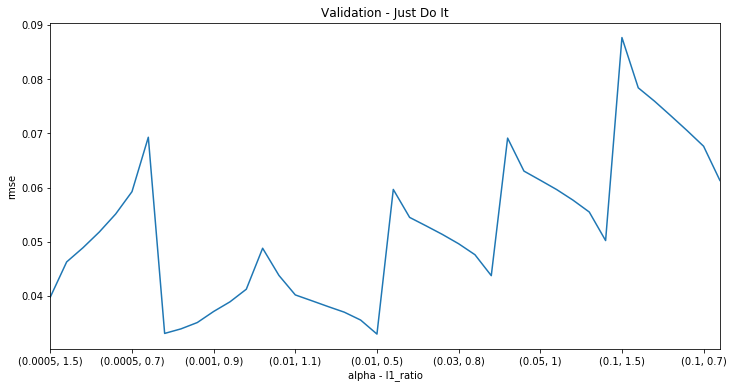

In [140]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index = idx)
p_cv_elastic.plot(title = "Validation - Just Do It")
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

Text(0, 0.5, 'rmse')

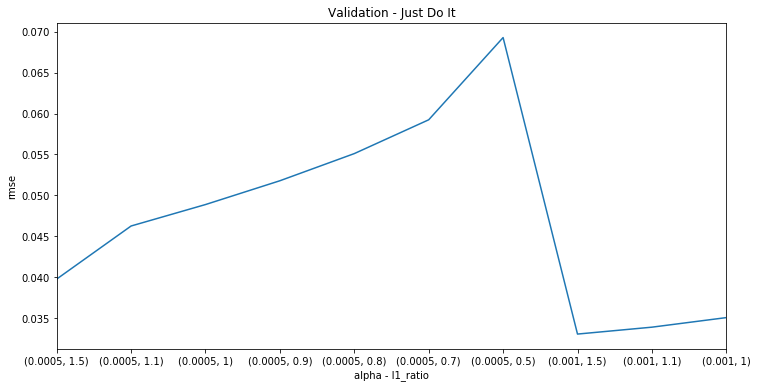

In [149]:
# Zoom in to the first 10 parameter pairs
plt.rcParams['figure.figsize'] = (12, 6)
idx = list(product(alphas, l1_ratios))[:10]
p_cv_elastic = pd.Series(cv_elastic[:10], index = idx)
p_cv_elastic.plot(title = "Validation - Just Do It")
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

In [86]:
elastic = ElasticNet(alpha=0.0005, l1_ratio=0.5, random_state=SEED)
elastic.fit(X_train_smote, y_train_res)

ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=1888, selection='cyclic', tol=0.0001, warm_start=False)

In [87]:
imp_coef(elastic)

,0
ENSG00000279115.1,0.013667
ENSG00000196748.9,0.011953
ENSG00000218358.2,0.011667
ENSG00000232216.1,0.010388
ENSG00000211950.2,0.007904
ENSG00000123364.4,0.007615
ENSG00000234743.1,0.005498
ENSG00000253755.1,0.005303
ENSG00000259847.1,0.003624
ENSG00000269416.5,0.003496


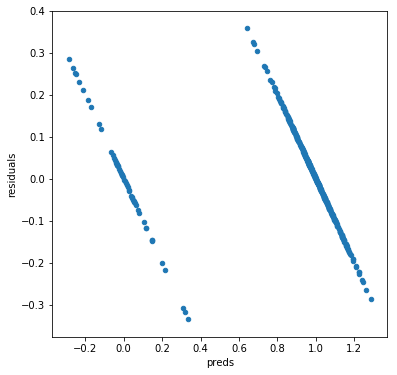

In [152]:
#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":elastic.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [153]:
rmse = np.sqrt(np.mean((preds['true']-preds['preds'])**2))
print ('RMSE: {0:.4f}'.format(rmse))

RMSE: 0.1146


In [154]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f' %  r2_score(preds['true'], preds['preds']))

R^2 train: 0.895


In [89]:
coef = pd.Series(elastic.coef_, index = X_train_smote.columns)

In [90]:
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 1345 variables and eliminated the other 6919 variables


In [91]:
imp_coef = pd.concat([coef.sort_values().head(25),
                     coef.sort_values().tail(25)])

Text(0.5, 1.0, 'Coefficients in the Elastic Net Model')

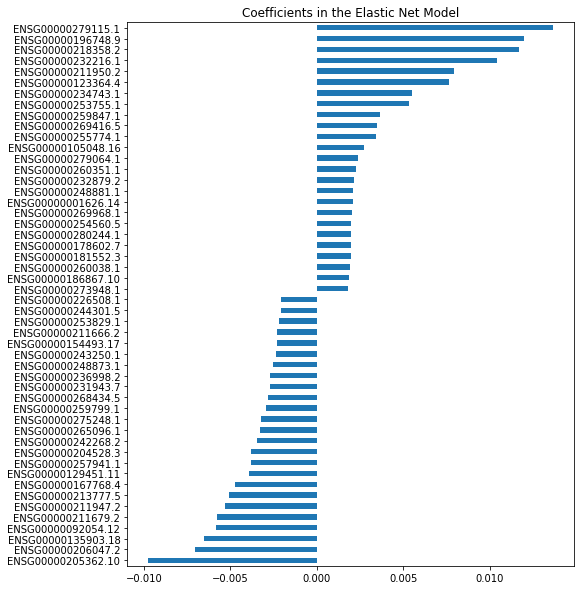

In [92]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

### Direct comparison vanilla Lasso/Elastic

In [162]:
lm_lasso = Lasso(random_state=SEED)
lm_elastic = ElasticNet(random_state=SEED)

In [163]:
lm_lasso.fit(X_train_smote, y_train_res)
lm_elastic.fit(X_train_smote, y_train_res)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=1888, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
#imp_coef(lm_lasso)

In [171]:
ft_importances_lm_lasso = pd.Series(lm_lasso.coef_, index=X_train_smote.columns)
ft_importances_lm_lasso.sort_values(ascending=False).head(20)

ENSG00000170373.8    0.018887
ENSG00000262533.1    0.016066
ENSG00000229237.2    0.004283
ENSG00000219928.2    0.003385
ENSG00000230838.1    0.000915
ENSG00000273450.1   -0.000000
ENSG00000239528.1   -0.000000
ENSG00000249639.1    0.000000
ENSG00000269526.1    0.000000
ENSG00000273233.1    0.000000
ENSG00000253660.1    0.000000
ENSG00000260558.1   -0.000000
ENSG00000273950.1    0.000000
ENSG00000261949.5    0.000000
ENSG00000180383.3   -0.000000
ENSG00000271623.1   -0.000000
ENSG00000239899.3   -0.000000
ENSG00000256861.1    0.000000
ENSG00000275343.1   -0.000000
ENSG00000276150.1   -0.000000
dtype: float64

In [ ]:
#imp_coef(lm_elastic)

In [189]:
ft_importances_lm_elastic = pd.Series(lm_elastic.coef_, index=X_train_smote.columns)
ft_importances_lm_elastic.sort_values(ascending=False).head(20)

ENSG00000262533.1    0.014027
ENSG00000170373.8    0.013851
ENSG00000229237.2    0.008707
ENSG00000230838.1    0.007433
ENSG00000224126.2    0.005796
ENSG00000244538.1    0.004818
ENSG00000219928.2    0.003885
ENSG00000235734.4    0.002906
ENSG00000256861.1    0.000000
ENSG00000239528.1   -0.000000
ENSG00000249639.1    0.000000
ENSG00000253660.1    0.000000
ENSG00000269526.1    0.000000
ENSG00000260558.1   -0.000000
ENSG00000273950.1    0.000000
ENSG00000261949.5    0.000000
ENSG00000180383.3   -0.000000
ENSG00000271623.1   -0.000000
ENSG00000273450.1   -0.000000
ENSG00000273233.1    0.000000
dtype: float64

In [173]:
# R2 value

np.round(lm_lasso.score(X_test, y_test)*100,2)

65.27

In [174]:
np.round(lm_elastic.score(X_test, y_test)*100,2)

86.17

### Elastic GS

In [176]:
elastic_hp = ElasticNet(random_state=SEED)
params = {"alpha": [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1], "l1_ratio": [1.5, 1.1, 1, 0.9, 0.8, 0.7, 0.5]}

gs = GridSearchCV(elastic_hp, param_grid=params, cv=5)
gs.fit(X_train_smote, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1], 'l1_ratio': [1.5, 1.1, 1, 0.9, 0.8, 0.7, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [99]:
print('Best Parameters',gs.best_params_)

NameError: name 'gs' is not defined

In [144]:
elastic_tuned = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=SEED)
elastic_tuned.fit(X_train_smote, y_train_res)

elastic_tuned_pred = elastic_tuned.predict(X_test)

print("Accuracy of logistic regression on test set: {:.2f}".format(elastic_tuned.score(X_test, y_test)))
print("Mean squared error: {:.2f}".format(mean_squared_error(y_test, elastic_tuned_pred)))

Accuracy of logistic regression on test set: 0.98
Mean squared error: 0.00


In [101]:
elastic_tuned.coef_

array([-0.,  0.,  0., ..., -0., -0.,  0.])

In [127]:
ft_importances_elastic_tuned = pd.DataFrame(elastic_tuned.coef_, index=X_train_smote.columns)
bla = ft_importances_elastic_tuned.sort_values(0, ascending=False).head(100)

In [106]:
print("Elastic Net picked " + str(sum(elastic_tuned.coef_ != 0)) + " variables and eliminated the other " +  str(sum(elastic_tuned.coef_ == 0)) + " variables")

Elastic Net picked 430 variables and eliminated the other 7834 variables


In [ ]:
list1 = lassoCV_coef.index.tolist()

In [115]:
list3 = ft_importances_elastic_tuned.sort_values(0, ascending=False).head(40).index.tolist()

In [116]:
set3 = set(list3)

In [118]:
set1 & set3

{'ENSG00000100721.10',
 'ENSG00000123500.9',
 'ENSG00000219928.2',
 'ENSG00000224126.2',
 'ENSG00000225558.1',
 'ENSG00000229237.2',
 'ENSG00000230734.1',
 'ENSG00000235734.4',
 'ENSG00000236060.2',
 'ENSG00000238249.2',
 'ENSG00000241431.1',
 'ENSG00000244538.1',
 'ENSG00000262533.1',
 'ENSG00000279473.1'}

In [119]:
set1 - set3

{'ENSG00000115386.5',
 'ENSG00000129824.15',
 'ENSG00000142789.19',
 'ENSG00000147434.8',
 'ENSG00000162840.4',
 'ENSG00000168530.15',
 'ENSG00000169474.4',
 'ENSG00000172867.3',
 'ENSG00000175646.3',
 'ENSG00000189398.5',
 'ENSG00000197616.11',
 'ENSG00000204866.8',
 'ENSG00000206913.1',
 'ENSG00000214881.4',
 'ENSG00000224557.7',
 'ENSG00000232679.1',
 'ENSG00000235912.1',
 'ENSG00000240247.6',
 'ENSG00000248583.1',
 'ENSG00000248873.1',
 'ENSG00000253683.1',
 'ENSG00000256500.5',
 'ENSG00000259738.1',
 'ENSG00000265415.1',
 'ENSG00000267143.1',
 'ENSG00000279084.1'}

### Elastic with SelectFromModel

In [120]:
# Elastic with SelectFromModel

clf_el = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=SEED)

# Set a minimum threshold of 0.25
sfm2 = SelectFromModel(clf_el, threshold=0.00001)
sfm2.fit(X_train_smote, y_train_res)
n_features = sfm2.transform(X_train_smote).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.

while n_features > 40:
    sfm.threshold += 0.00001
    X_transform2 = sfm2.transform(X_train_smote)
    n_features2 = X_transform2.shape[1]
    
n_features2

KeyboardInterrupt: 

In [132]:
d = {"metod": bla.index.tolist()}
d

{'metod': ['ENSG00000238249.2',
  'ENSG00000235734.4',
  'ENSG00000229237.2',
  'ENSG00000224126.2',
  'ENSG00000234743.1',
  'ENSG00000262533.1',
  'ENSG00000123500.9',
  'ENSG00000279473.1',
  'ENSG00000241431.1',
  'ENSG00000230838.1',
  'ENSG00000219928.2',
  'ENSG00000244538.1',
  'ENSG00000230734.1',
  'ENSG00000204429.4',
  'ENSG00000239642.5',
  'ENSG00000100721.10',
  'ENSG00000225558.1',
  'ENSG00000228168.1',
  'ENSG00000249141.1',
  'ENSG00000236768.1',
  'ENSG00000266341.1',
  'ENSG00000275431.1',
  'ENSG00000243063.1',
  'ENSG00000220875.1',
  'ENSG00000166961.14',
  'ENSG00000234174.1',
  'ENSG00000236060.2',
  'ENSG00000271127.1',
  'ENSG00000232993.1',
  'ENSG00000281383.1',
  'ENSG00000253755.1',
  'ENSG00000280178.1',
  'ENSG00000280244.1',
  'ENSG00000183308.6',
  'ENSG00000268854.1',
  'ENSG00000277619.1',
  'ENSG00000255351.1',
  'ENSG00000258064.1',
  'ENSG00000232177.1',
  'ENSG00000238741.1',
  'ENSG00000274266.1',
  'ENSG00000231351.2',
  'ENSG00000207008.1',


In [129]:
bla.index

Index(['ENSG00000238249.2', 'ENSG00000235734.4', 'ENSG00000229237.2',
       'ENSG00000224126.2', 'ENSG00000234743.1', 'ENSG00000262533.1',
       'ENSG00000123500.9', 'ENSG00000279473.1', 'ENSG00000241431.1',
       'ENSG00000230838.1', 'ENSG00000219928.2', 'ENSG00000244538.1',
       'ENSG00000230734.1', 'ENSG00000204429.4', 'ENSG00000239642.5',
       'ENSG00000100721.10', 'ENSG00000225558.1', 'ENSG00000228168.1',
       'ENSG00000249141.1', 'ENSG00000236768.1', 'ENSG00000266341.1',
       'ENSG00000275431.1', 'ENSG00000243063.1', 'ENSG00000220875.1',
       'ENSG00000166961.14', 'ENSG00000234174.1', 'ENSG00000236060.2',
       'ENSG00000271127.1', 'ENSG00000232993.1', 'ENSG00000281383.1',
       'ENSG00000253755.1', 'ENSG00000280178.1', 'ENSG00000280244.1',
       'ENSG00000183308.6', 'ENSG00000268854.1', 'ENSG00000277619.1',
       'ENSG00000255351.1', 'ENSG00000258064.1', 'ENSG00000232177.1',
       'ENSG00000238741.1', 'ENSG00000274266.1', 'ENSG00000231351.2',
       'ENSG000002

In [42]:
def elastic_net(X_train_smote, y_train_res, X_test, y_test, random_state=1888, alpha=0.01, l1_ratio=0.5, n_features=100):
    clf = ElasticNet(random_state=random_state, alpha=alpha, l1_ratio=l1_ratio)
    clf.fit(X_train_smote, y_train_res)
    
    clf.pred = clf.predict(X_test)
    
    print("Accuracy of elastic net: {:.2f}".format(clf.score(X_test, y_test)))
    print("Elastic net mean squared error: {:.2f}".format(mean_squared_error(y_test, clf.pred)))
    
    ft_imp = pd.DataFrame(clf.coef_, index=X_train_smote.columns)
    ft_sort = ft_imp.sort_values(0, ascending=False)
    imp_coef = pd.concat([ft_sort.head(int(n_features/2)), ft_sort.tail(int(n_features/2))])
        
    selected_features = imp_coef.index.tolist()
    feature_importances = imp_coef.iloc[:,0].tolist()

    dictionary = {"Elastic Net": [selected_features, feature_importances]}
    
    return dictionary 

elastic_net(X_train_smote, y_train_res, X_test, y_test, random_state=1888)

Accuracy of elastic net: 0.91
Elastic net mean squared error: 0.01


{'Elastic Net': [['ENSG00000229237.2',
   'ENSG00000219928.2',
   'ENSG00000256210.3',
   'ENSG00000224126.2',
   'ENSG00000259357.2',
   'ENSG00000170369.3',
   'ENSG00000235734.4',
   'ENSG00000254829.1',
   'ENSG00000260265.1',
   'ENSG00000262533.1',
   'ENSG00000029559.6',
   'ENSG00000280286.1',
   'ENSG00000223808.1',
   'ENSG00000257634.1',
   'ENSG00000276292.1',
   'ENSG00000236060.2',
   'ENSG00000277194.1',
   'ENSG00000232767.1',
   'ENSG00000257607.1',
   'ENSG00000214782.7',
   'ENSG00000280827.1',
   'ENSG00000207145.1',
   'ENSG00000232355.2',
   'ENSG00000106541.11',
   'ENSG00000238622.1',
   'ENSG00000216331.1',
   'ENSG00000249599.1',
   'ENSG00000222489.1',
   'ENSG00000269032.1',
   'ENSG00000278344.1',
   'ENSG00000269900.3',
   'ENSG00000256007.1',
   'ENSG00000267059.2',
   'ENSG00000199293.1',
   'ENSG00000258377.1',
   'ENSG00000243339.3',
   'ENSG00000279064.1',
   'ENSG00000264714.1',
   'ENSG00000273464.1',
   'ENSG00000252797.1',
   'ENSG00000256034.1',


### XGBoost

In [11]:
from xgboost import XGBClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [15]:
xgb = XGBClassifier()

#parameters = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30], #so called `eta` value
#              'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
#              'min_child_weight': [1, 3, 5, 7 ],
#              'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
#              'seed': [1888]}

parameters = {'learning_rate': [0.01, 0.05],
              'max_depth': [3, 4, 5, 7],
              'min_child_weight': [1, 3],
              'colsample_bytree': [0.4, 0.5, 0.7],
              'seed': [1888]}

xgb_gs = GridSearchCV(xgb,
                      param_grid=parameters,
                      n_jobs=1, 
                      cv=5, 
                      scoring='roc_auc',
                      verbose=2)

xgb_gs.fit(X_train_smote, y_train_res)
xgb_gs.best_score_, xgb_gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=1, seed=1888 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=1, seed=1888, total=  24.3s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=1, seed=1888 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s


[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=1, seed=1888, total=  27.8s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=1, seed=1888 
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=1, seed=1888, total=  25.5s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=1, seed=1888 
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=1, seed=1888, total=  24.1s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=1, seed=1888 
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=1, seed=1888, total=  25.5s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=3, seed=1888 
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=3, seed=1888, total=  21.2s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=3, min_child_weight=3, seed=1888 
[CV]  colsample

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 113.4min finished


(1.0,
 {'colsample_bytree': 0.4,
  'learning_rate': 0.01,
  'max_depth': 3,
  'min_child_weight': 1,
  'seed': 1888})

In [ ]:
parameters = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['binary:logistic'],
              'learning_rate': [0.01, 0.05],
              'max_depth': [3, 4, 5],
              'min_child_weight': [1, 3, 5, 7 ],
              #'silent': [1],
              #'subsample': [0.8],
              'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
              #'n_estimators': [5], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              'seed': 1888}

In [ ]:
df_loop = pd.DataFrame(X_train_res, columns=X_train.columns)

for _ in range(2):
    
    from sklearn.metrics import f1_score # import again because it works like that :)

    # Random Forests for Boruta
    rf_boruta = RandomForestClassifier(n_jobs=-1, random_state=SEED)

    # Perform Boruta
    boruta = BorutaPy(rf_boruta, n_estimators='auto', verbose=2,
                      alpha=0.005, max_iter=30, perc=100, random_state=SEED)
    boruta.fit(df_loop.values, y_train_res)

    # Select features and fit Logistic Regression

    cols = df_loop.columns[boruta.support_]
    df_loop = df_loop[cols]
    est_boruta = LogisticRegression(random_state=SEED)
    est_boruta.fit(df_loop, y_train_res)

    scores = cross_val_score(est_boruta, df_loop, y_train_res, cv=5)

    # Test accuracy
    #acc = accuracy_score(y_val, est_boruta.predict(X_val[cols1]))
    f1_score = f1_score(y_val, est_boruta.predict(X_val[cols]))

    print('Number of features selected: {}'.format(len(cols)))
    #print('Test Accuracy {:.5f}'.format(acc))
    print("F1 score {:.5f}".format(f1_score))
    print("CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [13]:
import time

### RFECV

In [31]:
start = time.time()

estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)

selector = selector.fit(X_train_smote, y_train_res)

print('Accuracy of RFE: {:.3f}'.format(selector.score(X_test, y_test)))

print('Finished in {:.1f} min\n'.format((time.time() - start) / 60))
        
# Add features and feature importance to dictionary
#selected_features = X_train.columns[selector.support_].tolist()
#feature_importances = [1 for x in range(len(selected_features))]

KeyboardInterrupt: 